In [1]:
# from scluster import SCluster
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import matplotlib.colors as colors

from pathlib import Path

from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from hdbscan import HDBSCAN
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

In [2]:
data_dir = Path(Path.cwd().parent, 'data/interim')
models_dir = Path(Path.cwd().parent, 'models')

2888

In [9]:
hdbscan_res = sorted([path for path in data_dir.glob('*hdbscan*.csv')])
dbscan_res = sorted([path for path in data_dir.glob('*dbscan*.csv')])
kmeans_res = sorted([path for path in data_dir.glob('*km*.csv')])

In [10]:
len(kmeans_res)

7

In [4]:
# define variables
data= pd.read_csv(Path('../data/raw/data_3.csv'))

In [5]:
data

,num,x,y
0,1,32.205609,31.794388
1,2,31.231352,33.378132
2,3,30.438987,33.125897
3,4,30.062514,32.160704
4,5,29.671359,33.337847
...,...,...,...
7315,7316,31.664378,33.534468
7316,7317,31.662992,33.529399
7317,7318,31.666121,33.534270
7318,7319,31.662232,33.530855


In [6]:

# dictionary of clustering functions:
CLUSTERING = {'kmeans' : lambda df, k: KMeans(n_clusters = k).fit(df).labels_,
             'hdbscan' : lambda df, s: HDBSCAN(min_cluster_size = s).fit(df).labels_,
            'meanshift': lambda df, q: MeanShift(bandwidth=0.025*min(q,50)).fit(df).labels_}

# the clustering by silhouette object
class SCluster:
    """
    The object that calculate the clustering by silhouette.
    for each step, the object calculate the clustering labels,
    and then, calculate for each result the silhouette score.
    next, this code choose the labels with the best score.
    """
    def __init__(self,typ='kmeans', org=2, lim=20, stp=1, dup=0.95):
        """
        initialize the object
        :param typ: clustering type
        :param org: first value in the loop
        :param lim: last value in the loop
        :param stp: # values between each step
        :param dup: value for fix dataframe row length for silhouette
        """
        # initial parameters
        self.type= typ
        self.org = org
        self.lim = lim+1
        self.stp = stp
        self.dup = dup

        # clustering function
        self.function = CLUSTERING[self.type.lower()]

        # values for calculation
        self.max = -1
        self.scores = {}
        self.labels_= []

    def adapt_silhouette(self,labels):
        """
        calculate the silhouette value for the given dataframe
        :param labels: cluster labels
        :return: the dataframe silhouette score for the given labels
        """
        data, labels= self.df[labels > -1], labels[labels > -1]
        if data.shape[0] == 0: return -1
        while True:
            try:
                return silhouette_score(data, labels, sample_size=self.size)*(labels.shape[0]/self.n)
            except:
                self.size = int(self.size*self.dup)

    def fit(self,data):
        """
        fit the optimal cluster labels to the data
        :param data: input dataframe
        """
        self.n = data.shape[0]
        self.size = self.n
        self.df = data
        for i in range(self.org, self.lim , self.stp):
            label = self.function(self.df, i)
            silho = self.adapt_silhouette(label)
            self.scores[silho] = label
            self.max = silho if self.max<silho else self.max
            print(f'cluster kind: {self.type}, input value = {i}, silhouette = {round(silho,3)}')
        self.labels_ = self.scores[self.max]
        return self

In [7]:
typ = 'kmeans'
org = 4 
lim = 10 
stp = 1

# application
data['labels'] = SCluster(typ=typ, org=org ,lim=lim, stp=stp).fit(data).labels_

cluster kind: kmeans, input value = 4, silhouette = 0.572
cluster kind: kmeans, input value = 5, silhouette = 0.561
cluster kind: kmeans, input value = 6, silhouette = 0.553
cluster kind: kmeans, input value = 7, silhouette = 0.548
cluster kind: kmeans, input value = 8, silhouette = 0.544
cluster kind: kmeans, input value = 9, silhouette = 0.541
cluster kind: kmeans, input value = 10, silhouette = 0.538


In [8]:
data['labels'].unique()

array([0, 2, 1, 3], dtype=int32)

In [9]:
typ = 'hdbscan'
org = 4 
lim = 10 
stp = 1

# application
data['labels'] = SCluster(typ=typ, org=org ,lim=lim, stp=stp).fit(data).labels_

cluster kind: hdbscan, input value = 4, silhouette = 0.042
cluster kind: hdbscan, input value = 5, silhouette = 0.402
cluster kind: hdbscan, input value = 6, silhouette = 0.295
cluster kind: hdbscan, input value = 7, silhouette = 0.401
cluster kind: hdbscan, input value = 8, silhouette = 0.403
cluster kind: hdbscan, input value = 9, silhouette = 0.471
cluster kind: hdbscan, input value = 10, silhouette = 0.571


In [ ]:
typ = 'meanshift'
org = 4 
lim = 10 
stp = 1

# application
data['labels'] = SCluster(typ=typ, org=org ,lim=lim, stp=stp).fit(data).labels_

In [24]:
df = pd.read_csv('../data/interim/dbscan_eval.csv')
df['prop_noise'] = df['n_noise'].div(df['size'])
df = df.dropna().reset_index(drop=True)

In [27]:
df

,size,min_pts,eps,n_cluster,n_noise,sil_score,distance,prop_noise
0,10000,5,1.50,2,9785,0.962297,euclidean,0.978500
1,10000,5,1.75,2,9777,0.927402,euclidean,0.977700
2,10000,10,1.75,2,9779,0.936524,euclidean,0.977900
3,15000,5,1.00,2,14691,0.960552,euclidean,0.979400
4,15000,5,1.25,2,14680,0.939960,euclidean,0.978667
...,...,...,...,...,...,...,...,...
201,80000,25,1.00,2,78330,0.935588,euclidean,0.979125
202,80000,30,1.00,2,78332,0.936456,euclidean,0.979150
203,80000,35,1.00,2,78332,0.936456,euclidean,0.979150
204,80000,40,1.00,2,78332,0.936456,euclidean,0.979150


In [8]:
df.sort_values(by='sil_score', ascending=False)

,size,min_pts,eps,n_cluster,n_noise,sil_score,distance
921,60000,5,0.50,2,58831,0.979335,euclidean
572,40000,10,0.75,2,39216,0.978272,euclidean
391,30000,5,0.75,2,29414,0.976978,euclidean
1191,75000,5,0.50,2,73546,0.976040,euclidean
301,25000,5,0.75,2,24510,0.973467,euclidean
...,...,...,...,...,...,...,...
685,45000,25,1.25,2,44002,0.892659,euclidean
684,45000,20,1.25,2,44000,0.891375,euclidean
683,45000,15,1.25,2,43998,0.889944,euclidean
682,45000,10,1.25,2,43998,0.889944,euclidean


In [28]:
df.describe()

,size,min_pts,eps,n_cluster,n_noise,sil_score,prop_noise
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,49296.116505,20.582524,1.059466,2.004854,48269.325243,0.932580,0.979046
std,18815.268436,12.770029,0.219023,0.069673,18436.760153,0.023647,0.000830
min,10000.000000,5.000000,0.500000,2.000000,9777.000000,0.889944,0.977400
25%,35000.000000,10.000000,1.000000,2.000000,34264.750000,0.907483,0.978275
50%,50000.000000,20.000000,1.000000,2.000000,48907.000000,0.935095,0.979103
75%,65000.000000,30.000000,1.250000,2.000000,63637.750000,0.946390,0.979489
max,80000.000000,45.000000,1.750000,3.000000,78448.000000,0.979335,0.981114


In [10]:
df[df.n_cluster==3]

,size,min_pts,eps,n_cluster,n_noise,sil_score,distance
1031,65000,5,1.0,3,63625,0.907508,euclidean


In [13]:
df.sort_values(by='sil_score', ascending=False)

61       6.785714
71       6.780166
72       6.781553
131     10.187933
141     10.180305
          ...    
1305    54.320388
1306    54.321775
1307    54.321775
1308    54.321775
1309    54.321775
Name: n_noise, Length: 206, dtype: float64

In [23]:
df

,size,min_pts,eps,n_cluster,n_noise,sil_score,distance,prop_noise
61,10000,5,1.50,2,9785,0.962297,euclidean,0.978500
71,10000,5,1.75,2,9777,0.927402,euclidean,0.977700
72,10000,10,1.75,2,9779,0.936524,euclidean,0.977900
131,15000,5,1.00,2,14691,0.960552,euclidean,0.979400
141,15000,5,1.25,2,14680,0.939960,euclidean,0.978667
...,...,...,...,...,...,...,...,...
1305,80000,25,1.00,2,78330,0.935588,euclidean,0.979125
1306,80000,30,1.00,2,78332,0.936456,euclidean,0.979150
1307,80000,35,1.00,2,78332,0.936456,euclidean,0.979150
1308,80000,40,1.00,2,78332,0.936456,euclidean,0.979150


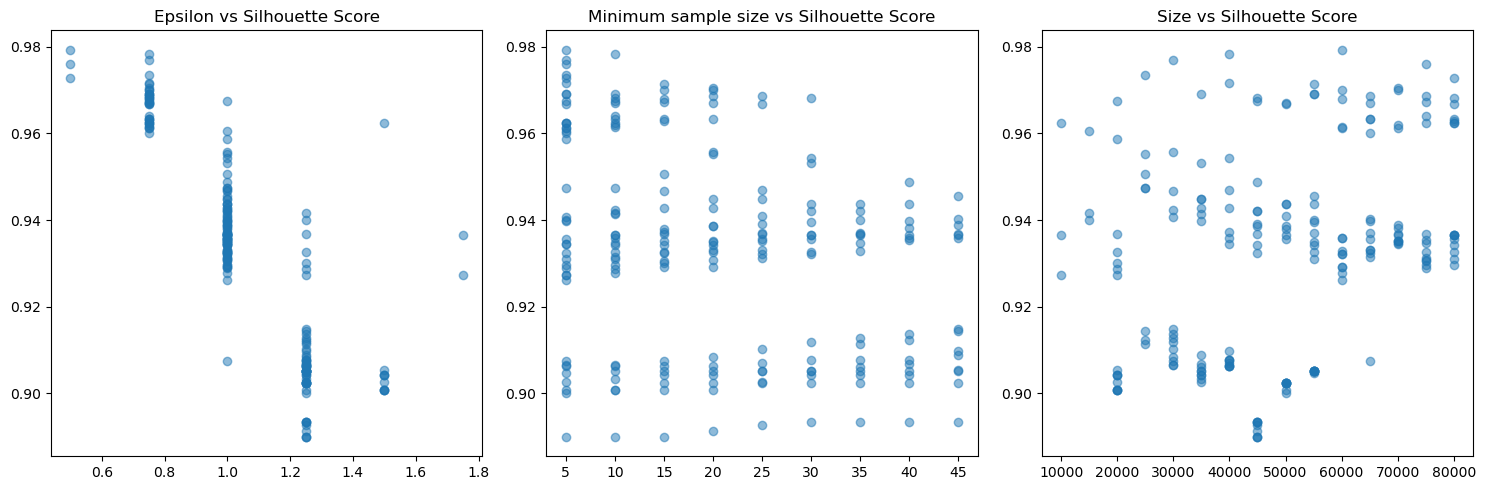

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].scatter(df['eps'], df['sil_score'], alpha=0.5)
axes[0].set_title('Epsilon vs Silhouette Score')
axes[1].scatter(df['min_pts'], df['sil_score'], alpha=0.5)
axes[1].set_title('Minimum sample size vs Silhouette Score')
axes[2].scatter(df['size'], df['sil_score'], alpha=0.5)
axes[2].set_title('Size vs Silhouette Score')

plt.show()

In [67]:
df.sort_values(by=['sil_score','eps','min_pts'], ascending=False)

,size,min_pts,eps,n_cluster,n_noise,sil_score,distance,prop_noise
135,60000,5,0.50,2,58831,0.979335,euclidean,0.980517
61,40000,10,0.75,2,39216,0.978272,euclidean,0.980400
30,30000,5,0.75,2,29414,0.976978,euclidean,0.980467
176,75000,5,0.50,2,73546,0.976040,euclidean,0.980613
22,25000,5,0.75,2,24510,0.973467,euclidean,0.980400
...,...,...,...,...,...,...,...,...
91,45000,25,1.25,2,44002,0.892659,euclidean,0.977822
90,45000,20,1.25,2,44000,0.891375,euclidean,0.977778
89,45000,15,1.25,2,43998,0.889944,euclidean,0.977733
88,45000,10,1.25,2,43998,0.889944,euclidean,0.977733


In [143]:
df = pd.read_csv('../data/interim/eval_hdbscan_1663092427.csv')
df['prop_noise'] = df['n_noise'].div(df['size'])
df.shape

(196, 10)

In [53]:
df.dropna().sort_values(by='sl_score', ascending=False).head()

,distance,size,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,prop_noise
139,euclidean,15000,10,10,2,14684,0.948229,1235.441359,0.495148,0.978933
148,euclidean,15000,15,9,2,14682,0.944417,1190.105388,0.505794,0.978800
138,euclidean,15000,10,9,2,14682,0.944417,1190.105388,0.505794,0.978800
135,euclidean,15000,10,6,2,14681,0.941993,1145.309653,0.516310,0.978733
137,euclidean,15000,10,8,2,14681,0.941993,1145.309653,0.516310,0.978733


In [54]:
df.dropna().sort_values(by='ch_score', ascending=False).head()

,distance,size,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,prop_noise
139,euclidean,15000,10,10,2,14684,0.948229,1235.441359,0.495148,0.978933
148,euclidean,15000,15,9,2,14682,0.944417,1190.105388,0.505794,0.978800
138,euclidean,15000,10,9,2,14682,0.944417,1190.105388,0.505794,0.978800
135,euclidean,15000,10,6,2,14681,0.941993,1145.309653,0.516310,0.978733
145,euclidean,15000,15,6,2,14681,0.941993,1145.309653,0.516310,0.978733


In [56]:
df.dropna().sort_values(by='db_score', ascending=True).head()

,distance,size,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,prop_noise
139,euclidean,15000,10,10,2,14684,0.948229,1235.441359,0.495148,0.978933
138,euclidean,15000,10,9,2,14682,0.944417,1190.105388,0.505794,0.978800
148,euclidean,15000,15,9,2,14682,0.944417,1190.105388,0.505794,0.978800
146,euclidean,15000,15,7,2,14681,0.941993,1145.309653,0.516310,0.978733
135,euclidean,15000,10,6,2,14681,0.941993,1145.309653,0.516310,0.978733


In [60]:
df.dropna().loc[df['size']==10000,:].sort_values(by='sl_score', ascending=False).head()

,distance,size,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,prop_noise
6,euclidean,10000,5,7,3,9751,0.858725,329.821897,0.623239,0.9751
5,euclidean,10000,5,6,3,9750,0.855532,331.174860,0.624758,0.9750
4,euclidean,10000,5,5,3,9749,0.852654,332.503426,0.626611,0.9749
3,euclidean,10000,5,4,3,9746,0.844731,331.863538,0.633159,0.9746
12,euclidean,10000,10,3,3,9741,0.830838,333.005425,0.661700,0.9741


In [144]:
df_1e4 = df.dropna().loc[df['size']==10000,:].sort_values(by='sl_score', ascending=False)

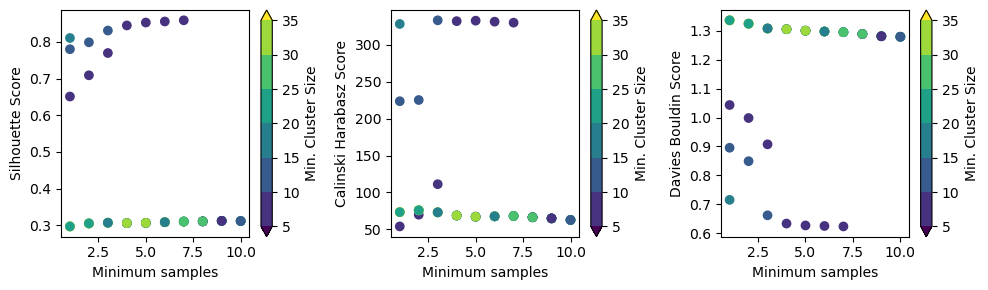

In [145]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))

cmap = mpl.cm.viridis
bounds = sorted(df_1e4['min_clt_size'].unique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

pc = axes[0].scatter(df_1e4['min_samples'], df_1e4['sl_score'], c=df_1e4['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[0], extend='both', label='Min. Cluster Size')
axes[0].set_xlabel('Minimum samples')
axes[0].set_ylabel('Silhouette Score')
pc = axes[1].scatter(df_1e4['min_samples'], df_1e4['ch_score'], c=df_1e4['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[1], extend='both', label='Min. Cluster Size')
axes[1].set_xlabel('Minimum samples')
axes[1].set_ylabel('Calinski Harabasz Score')
pc = axes[2].scatter(df_1e4['min_samples'], df_1e4['db_score'], c=df_1e4['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[2], extend='both', label='Min. Cluster Size')
axes[2].set_xlabel('Minimum samples')
axes[2].set_ylabel('Davies Bouldin Score')


plt.show()

In [146]:
df_15e3 = df.dropna().loc[df['size']==15000,:].sort_values(by='sl_score', ascending=False)

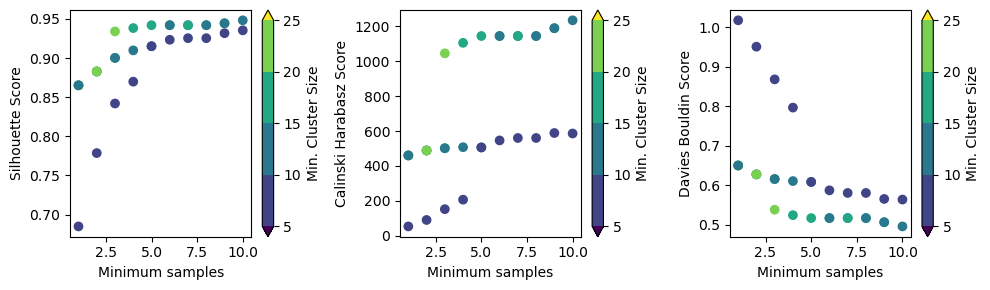

In [147]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))

cmap = mpl.cm.viridis
bounds = sorted(df_15e3['min_clt_size'].unique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

pc = axes[0].scatter(df_15e3['min_samples'], df_15e3['sl_score'], c=df_15e3['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[0], extend='both', label='Min. Cluster Size')
axes[0].set_xlabel('Minimum samples')
axes[0].set_ylabel('Silhouette Score')
pc = axes[1].scatter(df_15e3['min_samples'], df_15e3['ch_score'], c=df_15e3['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[1], extend='both', label='Min. Cluster Size')
axes[1].set_xlabel('Minimum samples')
axes[1].set_ylabel('Calinski Harabasz Score')
pc = axes[2].scatter(df_15e3['min_samples'], df_15e3['db_score'], c=df_15e3['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[2], extend='both', label='Min. Cluster Size')
axes[2].set_xlabel('Minimum samples')
axes[2].set_ylabel('Davies Bouldin Score')


plt.show()


In [61]:
df.dropna().loc[df['size']==15000,:].sort_values(by='sl_score', ascending=False).head()

,distance,size,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,prop_noise
139,euclidean,15000,10,10,2,14684,0.948229,1235.441359,0.495148,0.978933
148,euclidean,15000,15,9,2,14682,0.944417,1190.105388,0.505794,0.978800
138,euclidean,15000,10,9,2,14682,0.944417,1190.105388,0.505794,0.978800
136,euclidean,15000,10,7,2,14681,0.941993,1145.309653,0.516310,0.978733
147,euclidean,15000,15,8,2,14681,0.941993,1145.309653,0.516310,0.978733


In [63]:
df.dropna().loc[df['size']==15000,:].describe()

,size,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,prop_noise
count,33.0,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,15000.0,11.212121,4.909091,4.000000,14658.909091,0.902119,695.551777,0.612894,0.977261
std,0.0,5.452967,2.930056,4.690416,34.988716,0.054981,371.624620,0.125754,0.002333
min,15000.0,5.000000,1.000000,2.000000,14505.000000,0.684931,52.628608,0.495148,0.967000
25%,15000.0,5.000000,2.000000,2.000000,14651.000000,0.882855,488.559615,0.516310,0.976733
50%,15000.0,10.000000,5.000000,3.000000,14672.000000,0.923348,546.158933,0.586635,0.978133
75%,15000.0,15.000000,7.000000,3.000000,14681.000000,0.941993,1145.309653,0.627082,0.978733
max,15000.0,25.000000,10.000000,26.000000,14684.000000,0.948229,1235.441359,1.017613,0.978933


In [19]:
df[df.isnull().any(axis=1)].sort_values(by=['min_clt_size'])['min_clt_size'].value_counts()

40    10
45    10
50    10
55    10
60    10
35     7
20     2
15     1
30     1
Name: min_clt_size, dtype: int64

In [45]:
df2 = df.loc[:,['size', 'min_samples', 'min_clt_size', 'sl_score', 'ch_score','db_score']]

In [66]:
df2.groupby(by=['size','min_clt_size']).count().rsub(df.shape[1], axis=0)

min_samples  sl_score  ch_score  db_score
size  min_clt_size                                           
10000 5                       0         0         0         0
      10                      0         0         0         0
      15                      0         0         0         0
      20                      0         0         0         0
      25                      0         0         0         0
      30                      0         1         1         1
      35                      0         7         7         7
      40                      0        10        10        10
      45                      0        10        10        10
      50                      0        10        10        10
      55                      0        10        10        10
      60                      0        10        10        10
15000 5                       0         0         0         0
      10                      0         0         0         0
      15                      0         1         1         1
      20                      0         7         7         7
      25                      0         9         9         9
      30                      4        10        10        10

In [43]:
df2.shape

(176, 10)

,size,min_samples,min_clt_size,sl_score,ch_score,db_score
0,10000,1,5,0.650937,54.042323,1.043647
1,10000,2,5,0.708830,69.899506,0.998597
2,10000,3,5,0.769521,111.201050,0.907516
3,10000,4,5,0.844731,331.863538,0.633159
4,10000,5,5,0.852654,332.503426,0.626611
...,...,...,...,...,...,...
171,15000,2,30,NaN,NaN,NaN
172,15000,3,30,NaN,NaN,NaN
173,15000,4,30,NaN,NaN,NaN
174,15000,5,30,NaN,NaN,NaN


In [49]:
range(1,6)range(6,21,2)

TypeError: unsupported operand type(s) for |: 'range' and 'range'

In [58]:
[i for i in range(8,16)] + []

[8, 9, 10, 11, 12, 13, 14, 15]

In [2]:
df = pd.read_csv('../data/interim/eval_hdbscan_1663106951.csv')
df['prop_noise'] = df['n_noise'].div(df['size'])
df.shape

(490, 10)

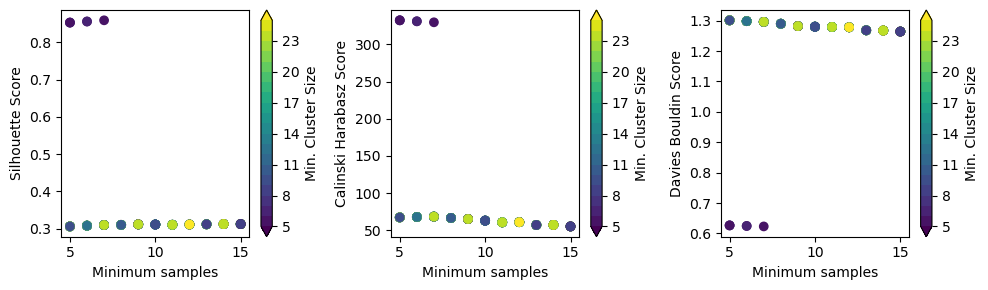

In [3]:
df_ = df.dropna().loc[df['size']==10000,:].sort_values(by='sl_score', ascending=False)
fig, axes = plt.subplots(1, 3, figsize=(10,3))

cmap = mpl.cm.viridis
bounds = sorted(df_['min_clt_size'].unique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

pc = axes[0].scatter(df_['min_samples'], df_['sl_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[0], extend='both', label='Min. Cluster Size')
axes[0].set_xlabel('Minimum samples')
axes[0].set_ylabel('Silhouette Score')
pc = axes[1].scatter(df_['min_samples'], df_['ch_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[1], extend='both', label='Min. Cluster Size')
axes[1].set_xlabel('Minimum samples')
axes[1].set_ylabel('Calinski Harabasz Score')
pc = axes[2].scatter(df_['min_samples'], df_['db_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[2], extend='both', label='Min. Cluster Size')
axes[2].set_xlabel('Minimum samples')
axes[2].set_ylabel('Davies Bouldin Score')


plt.show()

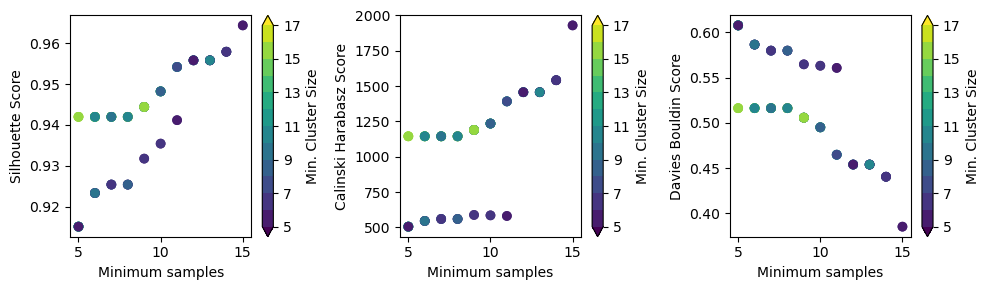

In [4]:
df_ = df.dropna().loc[df['size']==15000,:].sort_values(by='sl_score', ascending=False)
fig, axes = plt.subplots(1, 3, figsize=(10,3))

cmap = mpl.cm.viridis
bounds = sorted(df_['min_clt_size'].unique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

pc = axes[0].scatter(df_['min_samples'], df_['sl_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[0], extend='both', label='Min. Cluster Size')
axes[0].set_xlabel('Minimum samples')
axes[0].set_ylabel('Silhouette Score')
pc = axes[1].scatter(df_['min_samples'], df_['ch_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[1], extend='both', label='Min. Cluster Size')
axes[1].set_xlabel('Minimum samples')
axes[1].set_ylabel('Calinski Harabasz Score')
pc = axes[2].scatter(df_['min_samples'], df_['db_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[2], extend='both', label='Min. Cluster Size')
axes[2].set_xlabel('Minimum samples')
axes[2].set_ylabel('Davies Bouldin Score')


plt.show()

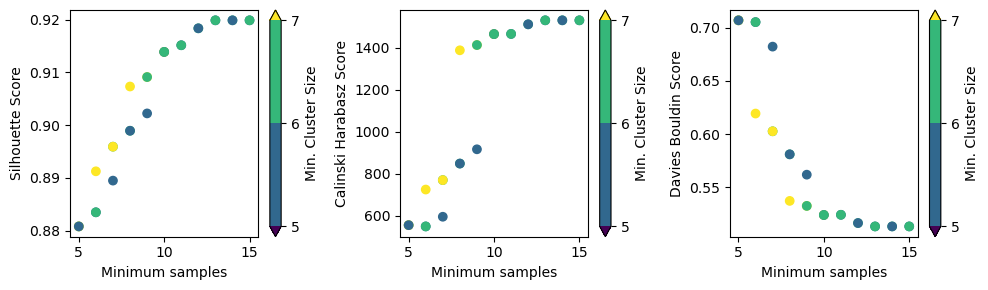

In [5]:
df_ = df.dropna().loc[df['size']==20000,:].sort_values(by='sl_score', ascending=False)
fig, axes = plt.subplots(1, 3, figsize=(10,3))

cmap = mpl.cm.viridis
bounds = sorted(df_['min_clt_size'].unique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

pc = axes[0].scatter(df_['min_samples'], df_['sl_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[0], extend='both', label='Min. Cluster Size')
axes[0].set_xlabel('Minimum samples')
axes[0].set_ylabel('Silhouette Score')
pc = axes[1].scatter(df_['min_samples'], df_['ch_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[1], extend='both', label='Min. Cluster Size')
axes[1].set_xlabel('Minimum samples')
axes[1].set_ylabel('Calinski Harabasz Score')
pc = axes[2].scatter(df_['min_samples'], df_['db_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[2], extend='both', label='Min. Cluster Size')
axes[2].set_xlabel('Minimum samples')
axes[2].set_ylabel('Davies Bouldin Score')


plt.show()

In [2]:
df1 = pd.read_csv('../data/interim/eval_cuML_hdbscan_1663254795.csv')
df2 = pd.read_csv('../data/interim/eval_cuML_hdbscan_1663255165.csv')
df3 = pd.read_csv('../data/interim/eval_cuML_hdbscan_1663255782.csv')

In [5]:
df = pd.concat([df1, df2, df3])

In [6]:
df

,distance,size,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,entropy
0,euclidean,20000,2,2,334,18562,0.371878,11.574863,1.098448,4.588767
1,euclidean,20000,2,3,103,19098,0.524244,24.003756,1.077850,2.961384
2,euclidean,20000,2,4,58,19312,0.645757,35.167229,1.082240,2.104872
3,euclidean,20000,3,2,131,18960,0.470295,19.887019,1.186265,3.490117
4,euclidean,20000,3,3,58,19188,0.573307,37.689557,1.113517,2.507123
...,...,...,...,...,...,...,...,...,...,...
49,euclidean,95000,3,3,159,69702,-0.005842,88.683386,1.243778,0.601789
50,euclidean,95000,3,4,106,92188,0.720450,86.902592,1.100490,1.877159
51,euclidean,95000,4,2,221,66391,0.026908,83.974713,1.381594,0.717149
52,euclidean,95000,4,3,121,69803,0.005362,104.355831,1.273383,0.562835


In [ ]:
df_ = df.dropna().sort_values(by=['sl_score'], ascending=False)

In [7]:
df.dropna().groupby('size').max('sl_score')

,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,entropy
size,,,,,,,,
20000,4,4,334,19389,0.718878,86.191299,1.186265,4.588767
25000,4,4,387,24234,0.705664,110.644039,1.273864,4.619733
30000,4,4,476,29156,0.741755,103.363754,1.218295,4.744110
35000,4,4,435,28381,0.056461,140.016260,1.292928,1.829200
40000,4,4,676,38898,0.762952,120.074379,1.284689,5.052522
45000,4,4,778,43684,0.721219,135.805173,1.307299,5.147128
50000,4,4,863,46307,0.350579,82.580041,1.229235,5.216996
55000,4,4,1017,50464,0.314710,97.971910,1.248333,5.319159
60000,4,4,1106,55298,0.330350,106.800650,1.370724,5.370608


In [ ]:
df.dropna().groupby('size').max('sl_score')

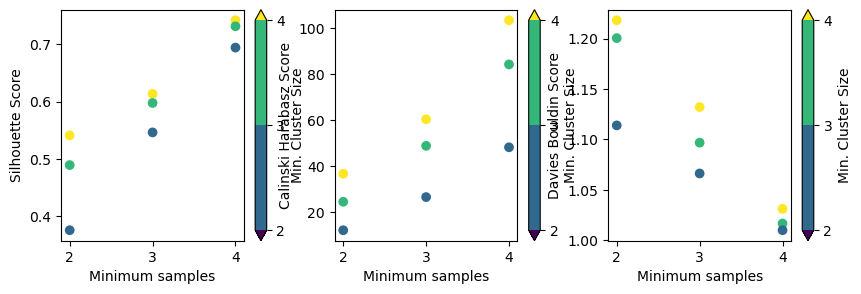

In [8]:
df_ = df.dropna().loc[df['size']==30000,:].sort_values(by='sl_score', ascending=False)
fig, axes = plt.subplots(1, 3, figsize=(10,3))

cmap = mpl.cm.viridis
bounds = sorted(df_['min_clt_size'].unique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

pc = axes[0].scatter(df_['min_samples'], df_['sl_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[0], extend='both', label='Min. Cluster Size')
axes[0].set_xlabel('Minimum samples')
axes[0].set_ylabel('Silhouette Score')
pc = axes[1].scatter(df_['min_samples'], df_['ch_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[1], extend='both', label='Min. Cluster Size')
axes[1].set_xlabel('Minimum samples')
axes[1].set_ylabel('Calinski Harabasz Score')
pc = axes[2].scatter(df_['min_samples'], df_['db_score'], c=df_['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[2], extend='both', label='Min. Cluster Size')
axes[2].set_xlabel('Minimum samples')
axes[2].set_ylabel('Davies Bouldin Score')


plt.show()